In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

In [5]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [6]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [7]:
date_set_path = "../temp_sets_100/"

In [8]:
cptevents_sample_df = read_csv_no_rowid(date_set_path + "cptevents.csv")

In [9]:
# Drop some null value
cptevents_sample_df.dropna(subset=['subject_id', 'hadm_id'], inplace=True, axis=0)

In [10]:
cptevents_sample_df.head()

,subject_id,hadm_id,costcenter,chartdate,cpt_cd,cpt_number,cpt_suffix,ticket_id_seq,sectionheader,subsectionheader,description
0,569,116412,ICU,NaN,99253,99253,NaN,1.0,Evaluation and management,Consultations,NaN
1,569,116412,ICU,NaN,99291,99291,NaN,2.0,Evaluation and management,Critical care services,NaN
2,569,116412,ICU,NaN,99291,99291,NaN,3.0,Evaluation and management,Critical care services,NaN
3,569,116412,ICU,NaN,99232,99232,NaN,4.0,Evaluation and management,Hospital inpatient services,NaN
4,2617,179233,ICU,NaN,99223,99223,NaN,1.0,Evaluation and management,Hospital inpatient services,NaN


In [11]:
# Drop useless colums
cptevents_sample_df.drop(['description', 'cpt_cd', 'ticket_id_seq'], axis=1, inplace=True)
# Because in this column with 573146 rows, just 22 rows is str type, so I just drop the row which is str
cptevents_sample_df.drop(cptevents_sample_df.loc[cptevents_sample_df['cpt_suffix'].isnull() == False].index, inplace=True)
cptevents_sample_df.drop(['cpt_suffix'], axis=1, inplace=True)

In [12]:
nan_count(cptevents_sample_df)

Total columns: 7
Total rows: 1546
--------------
subject_id             0
hadm_id                0
costcenter             0
chartdate           1282
cpt_number             0
sectionheader          0
subsectionheader       0
dtype: int64


In [13]:
# Set a initial time to replace the null time value 
nan_datetime = pd.to_datetime(0)

In [14]:
# Deal with null values
# cptevents_sample_df['ticket_id_seq'].fillna(value=0, inplace=True)
cptevents_sample_df['chartdate'].fillna(value=nan_datetime, inplace=True)

In [15]:
cptevents_sample_df.dtypes

subject_id           int64
hadm_id              int64
costcenter          object
chartdate           object
cpt_number           int64
sectionheader       object
subsectionheader    object
dtype: object

In [16]:
# Set type of columns
cptevents_sample_df['chartdate'] = pd.to_datetime(cptevents_sample_df['chartdate'])
# If keep the str row in, then set the column as 'str'
# cptevents_sample_df['cpt_cd'] = cptevents_sample_df['cpt_cd'].astype(int)
# cptevents_sample_df['ticket_id_seq'] = cptevents_sample_df['ticket_id_seq'].astype(int)

In [17]:
cptevents_sample_df.dtypes

subject_id                   int64
hadm_id                      int64
costcenter                  object
chartdate           datetime64[ns]
cpt_number                   int64
sectionheader               object
subsectionheader            object
dtype: object

In [18]:
nan_count(cptevents_sample_df)

Total columns: 7
Total rows: 1546
--------------
subject_id          0
hadm_id             0
costcenter          0
chartdate           0
cpt_number          0
sectionheader       0
subsectionheader    0
dtype: int64


In [19]:
cptevents_sample_df.dtypes

subject_id                   int64
hadm_id                      int64
costcenter                  object
chartdate           datetime64[ns]
cpt_number                   int64
sectionheader               object
subsectionheader            object
dtype: object

In [20]:
len(cptevents_sample_df)

1546

---

## Build model

In [21]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations
from sdv.constraints import Inequality

In [22]:
cptevents_sample_df.columns

Index(['subject_id', 'hadm_id', 'costcenter', 'chartdate', 'cpt_number',
       'sectionheader', 'subsectionheader'],
      dtype='object')

In [23]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id']
)
fixed_sectionheader_subsectionheader_constraint = FixedCombinations(
    column_names=['sectionheader', 'subsectionheader']
)

In [24]:
cptevents_constraints = [fixed_subject_hadm_icustay_constraint, fixed_sectionheader_subsectionheader_constraint]

In [25]:
model = CTGAN(
    constraints=cptevents_constraints, 
    batch_size=1000,
    generator_lr=0.0005,
    discriminator_lr=0.0005,
    cuda=True, 
    verbose=True, 
    epochs=200)

In [26]:
len(cptevents_sample_df)

1546

In [27]:
train_data = cptevents_sample_df.loc[0:1000, : ]
model.fit(train_data)

Epoch 1, Loss G:  2.6924,Loss D:  0.0048
Epoch 2, Loss G:  2.6375,Loss D: -0.0058
Epoch 3, Loss G:  2.6159,Loss D: -0.0275
Epoch 4, Loss G:  2.5969,Loss D: -0.0484
Epoch 5, Loss G:  2.6410,Loss D: -0.0800
Epoch 6, Loss G:  2.5401,Loss D: -0.0963
Epoch 7, Loss G:  2.4566,Loss D: -0.0879
Epoch 8, Loss G:  2.4428,Loss D: -0.0531
Epoch 9, Loss G:  2.2991,Loss D: -0.1030
Epoch 10, Loss G:  2.3547,Loss D: -0.1150
Epoch 11, Loss G:  2.3458,Loss D: -0.0822
Epoch 12, Loss G:  2.2934,Loss D: -0.0691
Epoch 13, Loss G:  2.3551,Loss D: -0.0529
Epoch 14, Loss G:  2.3778,Loss D: -0.1022
Epoch 15, Loss G:  2.4093,Loss D: -0.1206
Epoch 16, Loss G:  2.3680,Loss D: -0.1218
Epoch 17, Loss G:  2.3544,Loss D: -0.1569
Epoch 18, Loss G:  2.4552,Loss D: -0.1904
Epoch 19, Loss G:  2.4110,Loss D: -0.1464
Epoch 20, Loss G:  2.3939,Loss D: -0.2222
Epoch 21, Loss G:  2.4239,Loss D: -0.2301
Epoch 22, Loss G:  2.4214,Loss D: -0.1595
Epoch 23, Loss G:  2.3861,Loss D: -0.1312
Epoch 24, Loss G:  2.2039,Loss D: -0.0073
E

In [41]:
import cloudpickle

with open(date_set_path + "100_models/" + "cptevents_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [28]:
# model.save(date_set_path + "100_models/" + "cptevents_model.pkl")

In [29]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/cptevents_model.pkl"))

In [30]:
sample = model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 1001/1001 [00:00<00:00, 15716.41it/s]


In [31]:
len(sample)

1001

In [32]:
nan_count(sample)

Total columns: 7
Total rows: 1001
--------------
subject_id          0
hadm_id             0
costcenter          0
chartdate           0
cpt_number          0
sectionheader       0
subsectionheader    0
dtype: int64


In [33]:
sample.dtypes

subject_id                   int64
hadm_id                      int64
costcenter                  object
chartdate           datetime64[ns]
cpt_number                   int64
sectionheader               object
subsectionheader            object
dtype: object

In [34]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.41144607896803326

In [35]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4802263155042798

array([[<AxesSubplot:title={'center':'subject_id'}>,
        <AxesSubplot:title={'center':'hadm_id'}>],
       [<AxesSubplot:title={'center':'chartdate'}>,
        <AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

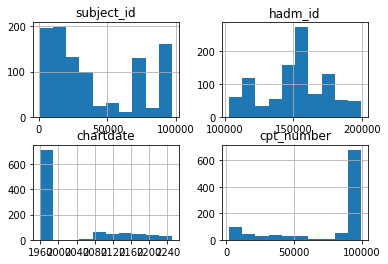

In [36]:
sample.sort_values('cpt_number').hist()

array([[<AxesSubplot:title={'center':'subject_id'}>,
        <AxesSubplot:title={'center':'hadm_id'}>],
       [<AxesSubplot:title={'center':'chartdate'}>,
        <AxesSubplot:title={'center':'cpt_number'}>]], dtype=object)

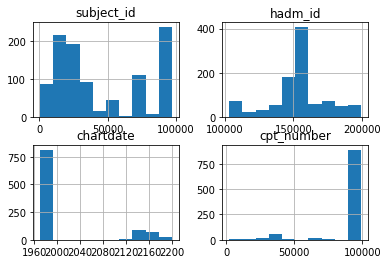

In [37]:
train_data.sort_values('cpt_number').hist()

<AxesSubplot:>

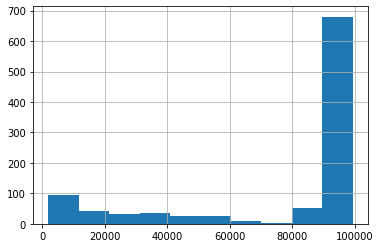

In [38]:
sample.sort_values('cpt_number')['cpt_number'].hist()

<AxesSubplot:>

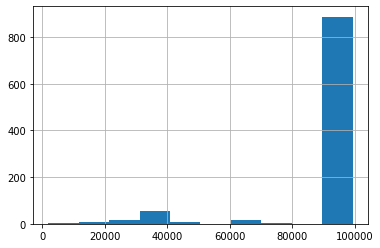

In [39]:
train_data.sort_values('cpt_number')['cpt_number'].hist()

In [40]:
# evaluate(sample, train_data, aggregate=False)